In [1]:
from src.efficient_kan import JKAN as KAN, JKANLinear as KANLinear

import jax
import jax.numpy as jnp
import jax.random as jr
import flax
import flax.linen as nn
import optax

import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import Tuple


In [2]:
def train_model(module, x, y, optimizer=optax.adam(1e-2), steps=100):
    vars = module.init(jr.key(0), x)
    vars, params = flax.core.pop(vars,"params")
    opt_state = optimizer.init(params)

    @jax.jit
    def update_step(params, vars, opt_state, x, y):
        def loss_fn(params):
            yhat = module.apply({"params": params, **vars}, x)
            return jnp.mean((y - yhat)**2)
        loss, grad = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = optimizer.update(grad, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss
    
    losses = []
    for _ in tqdm(range(steps)):
        params, opt_state, loss = update_step(params, vars, opt_state, x, y)
        losses.append(loss)

    def apply_fn(x):
        return module.apply({"params": params, **vars}, x)
    return losses, params, vars, apply_fn

def param_count(ps):
    return sum(p.size for p in jax.tree.leaves(ps))


100%|██████████| 200/200 [00:00<00:00, 444.12it/s]


Params: 28


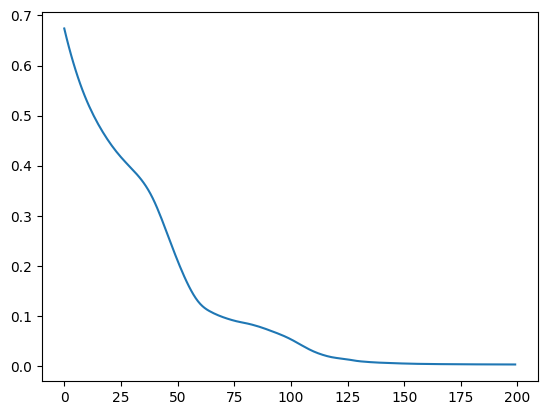

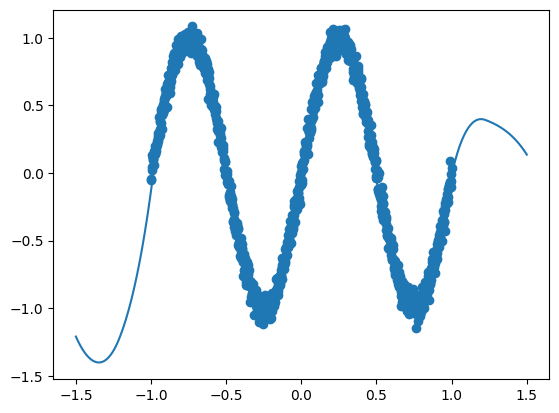

In [3]:
kan = KAN([2, 1], grid_size=3, spline_order=2)

x = jnp.linspace(-1, 1, 1024).reshape(-1, 1)
y = jnp.sin(2 * jnp.pi * x) + 0.051 * jr.normal(jr.key(1), x.shape)
x_test = jnp.linspace(-1.5, 1.5, 1024).reshape(-1, 1)

losses, params, vars, kan_apply = train_model(kan, x, y, steps=200)

print("Params:",param_count(params))

y_test = kan_apply(x_test)
plt.plot(losses)
plt.show()
plt.plot(x_test, y_test)
plt.scatter(x, y)

100%|██████████| 800/800 [00:00<00:00, 3607.43it/s]

Params: 97


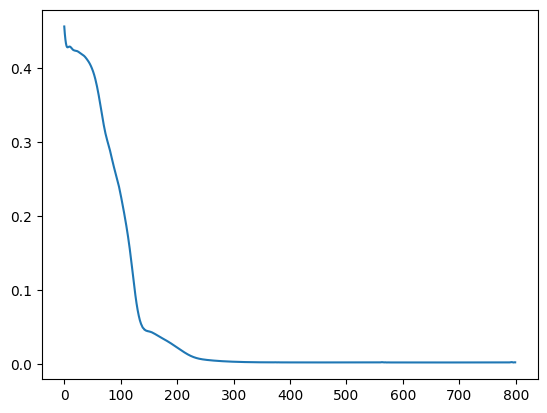

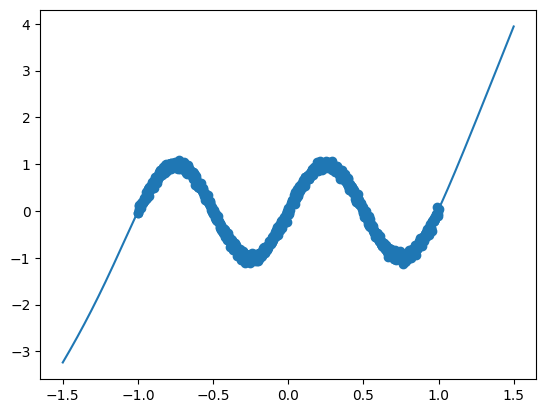

In [9]:
class MLP(nn.Module):
    features: Tuple[int,...] = (8,8,1)

    @nn.compact
    def __call__(self, x):
        for f in self.features[:-1]:
            x = nn.Dense(f)(x)
            x = jax.nn.silu(x)
        x = nn.Dense(self.features[-1])(x)
        return x
    
mlp = MLP()
losses, params, vars, mlp_apply = train_model(mlp, x, y, steps=800)

print("Params:",param_count(params))

y_test = mlp_apply(x_test)
plt.plot(losses)
plt.show()
plt.plot(x_test, y_test)
plt.scatter(x, y)